# 1. Importing Libraries

Just importing important libraries

In [1]:
# Important libraries
import numpy as np
import nengo
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import sys
import os

# Get the absolute path of the src folder
sys.path.insert(0, os.path.abspath(".."))

# Now you can import your script
from utils.DataManagerAndProcesser import GetDataAndBin


# 2. Loading Data

### 2.1 Basic File Properties

Make sure to save the entire raw data in 'Data Extration'.
There should be four files: MM_S1_raw.csv, MT_S1_raw.csv, MT_S2_raw.csv, MT_S3_raw.csv, 

In [2]:
# Change 'monkey' variable to the desired monkey dataset: MM_S1, MT_S1, MT_S2, MT_S3
monkey = "MT_S1"
neural_data, kinematic_data, n_neurons = GetDataAndBin(monkey)
# Neural Data: # Time bins x Neurons
# Kinematic Data: # Time bins x Kinematic Data

# 3. Building the Minimal Effort Learning Model

### 3.1 Setting up and Adjusting Model Parameters

In [6]:
# Getting the input and output data for the model

spikes = np.transpose(neural_data)

# Z-Score Kinematic Data
# kin_data = np.transpose(kinematic_data)
# kin_scaler = np.max(np.abs(kin_data))
# kin_data = kin_data / kin_scaler
kin_data = np.transpose(kinematic_data)
kin_data[0] = gaussian_filter1d(kin_data[0], sigma=50) 
kin_data[1] = gaussian_filter1d(kin_data[1], sigma=50)

# Center data
# kin_data_x_shift = np.mean(kin_data[0])
# kin_data_y_shift = np.mean(kin_data[1])
# kin_data[0] -= kin_data_x_shift
# kin_data[1] -= kin_data_y_shift

# Scale Data 
kin_data_x_scaler = np.max(np.abs(kin_data[0]))
kin_data_y_scaler = np.max(np.abs(kin_data[1]))
kin_data[0] /= kin_data_x_scaler
kin_data[1] /= kin_data_y_scaler

# Model information
dt = 0.01
dti = 1/dt
spikes = spikes*dti

# Parameters to change
ensemble_radius = 1
ensemble_synapse = 0.025
probe_synapse = 0.01

running_time = 800 # How long the model should run for
training_time = 0.5*running_time # WHen does the model stop learning

### 3.2 Implementing the Nengo Model

The image below is a visualization of the MELM model
![Architecture](MELM_architecture-A.png)

In [7]:
# Nengo Network Using Recorded Spikes as Input
np.random.seed(0)
with nengo.Network() as model:

    # Input signal
    input_node = nengo.Node(lambda t: spikes[:,int(t / dt) - 1])
    
    
    # Connect low-passed input to the first ensemble (neuron representation)
    representation_ensemble = nengo.Ensemble(n_neurons=50*n_neurons, dimensions=n_neurons, radius = ensemble_radius)
    nengo.Connection(input_node, representation_ensemble, synapse=0.2)

    # Secondary representation branc with recurrent connection
    representation_ensemble_recc = nengo.Ensemble(n_neurons=50*n_neurons, dimensions=n_neurons, radius = ensemble_radius)
    nengo.Connection(input_node, representation_ensemble_recc, synapse=0.2)
    rep_recur_con = nengo.Connection(representation_ensemble_recc, representation_ensemble_recc, synapse=0.2)

    # Connect first ensemble to output ensemble
    output_ensemble = nengo.Ensemble(n_neurons=2*50, dimensions=2, radius = ensemble_radius)
    learn_conn1 = nengo.Connection(representation_ensemble, output_ensemble,  function=lambda x: [0, 0], learning_rule_type=nengo.PES(learning_rate=1e-3))
    learn_conn2 = nengo.Connection(representation_ensemble_recc, output_ensemble,  function=lambda x: [0, 0], learning_rule_type=nengo.PES(learning_rate=1e-3))

    # Connect output to error
    error_ensemble = nengo.Ensemble(n_neurons=2*50, dimensions=2, radius = ensemble_radius)
    error_p = nengo.Probe(error_ensemble, synapse=probe_synapse)
    nengo.Connection(output_ensemble, error_ensemble)

    # Connect error to the learning connection
    nengo.Connection(error_ensemble, learn_conn1.learning_rule)
    nengo.Connection(error_ensemble, learn_conn2.learning_rule)

    # Get ground truth value
    truth_node = nengo.Node(lambda t: kin_data[:,int(t/dt) -1])
    nengo.Connection(truth_node, error_ensemble, transform=-1)

    # Probe for graphing
    p_post = nengo.Probe(output_ensemble, synapse=probe_synapse)

    # Stop learning after 80% of the running time has passed
    stop_learning = nengo.Node(output=lambda t: t >= training_time)
    nengo.Connection(
        stop_learning, error_ensemble.neurons, transform= -20 * np.ones((error_ensemble.n_neurons, 1))
    )

### 3.3 Running the Model and Plotting the Output

Build finished in 0:00:04.                                                      
Simulation finished in 0:01:17.                                                 


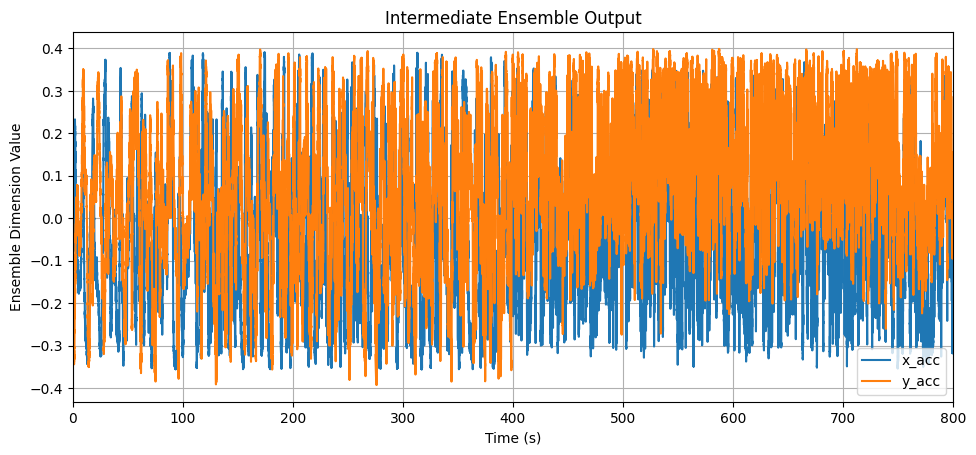

In [8]:
with nengo.Simulator(model, dt=dt, seed=0) as sim:
    sim.run(running_time)

fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_post])
pl.set_title("Intermediate Ensemble Output")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_acc", "y_acc"])
pl.grid()

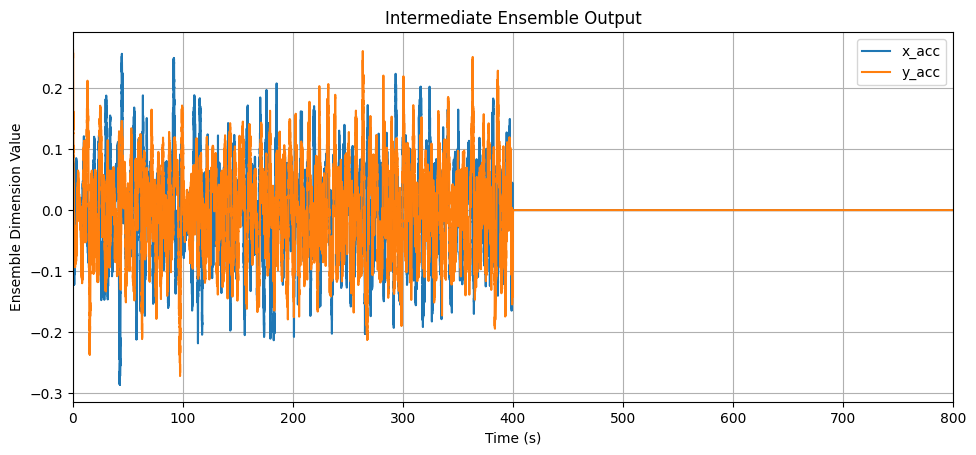

In [9]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[error_p])
pl.set_title("Intermediate Ensemble Output")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_acc", "y_acc"])
pl.grid()

# 4. Plotting and Comparing the Outputs

### 4.1 Plotting Predicted vs Actual Acceleration

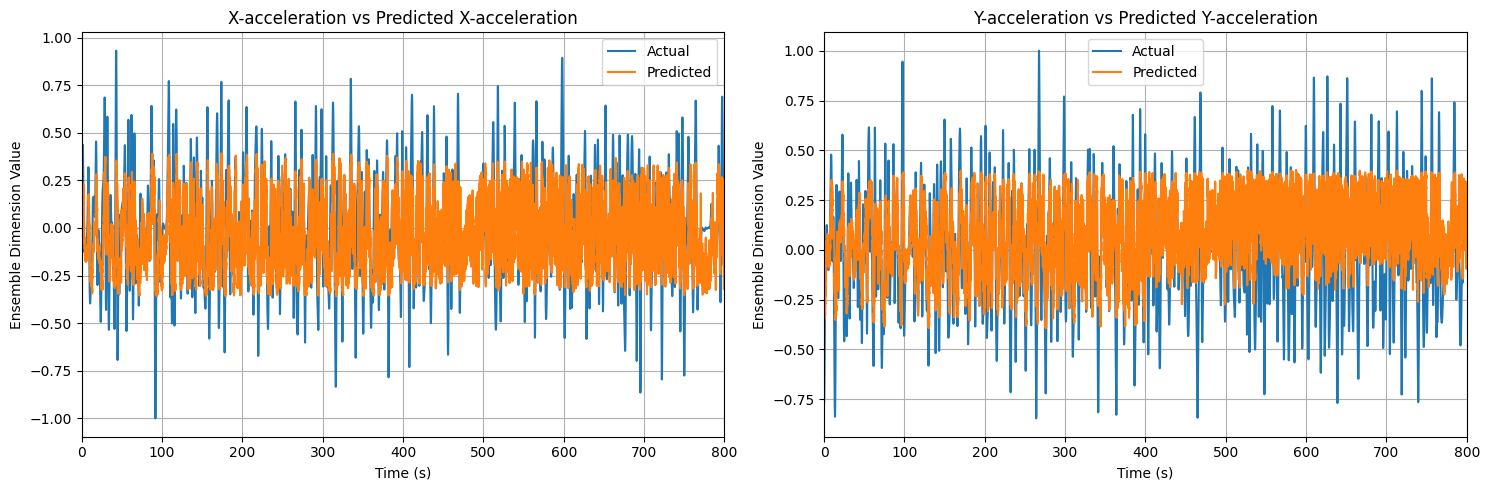

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(sim.trange(), kin_data[0, 0:len(sim.trange())])
ax1.plot(sim.trange(), sim.data[p_post][:, 0])
ax1.set_title("X-acceleration vs Predicted X-acceleration")
ax1.set_xlim((0,np.max(sim.trange())))
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Ensemble Dimension Value")
ax1.legend(["Actual", "Predicted"])
ax1.grid()

ax2.plot(sim.trange(), kin_data[1, 0:len(sim.trange())])
ax2.plot(sim.trange(), sim.data[p_post][:, 1])
ax2.set_title("Y-acceleration vs Predicted Y-acceleration")
ax2.set_xlim((0,np.max(sim.trange())))
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Ensemble Dimension Value")
ax2.legend(["Actual", "Predicted"])
ax2.grid()

fig.tight_layout()
plt.show()

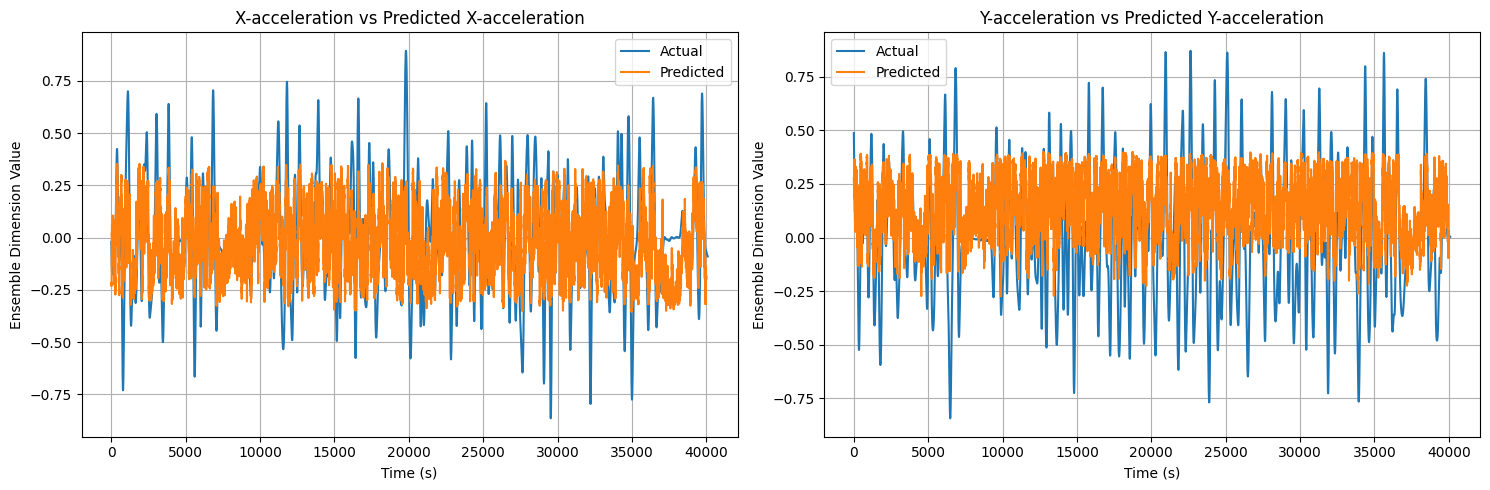

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(kin_data[0, int(training_time/dt):])
ax1.plot(sim.data[p_post][int(training_time/dt):, 0])
ax1.set_title("X-acceleration vs Predicted X-acceleration")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Ensemble Dimension Value")
ax1.legend(["Actual", "Predicted"])
ax1.grid()

ax2.plot(kin_data[1, int(training_time/dt):])
ax2.plot(sim.data[p_post][int(training_time/dt):, 1])
ax2.set_title("Y-acceleration vs Predicted Y-acceleration")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Ensemble Dimension Value")
ax2.legend(["Actual", "Predicted"])
ax2.grid()

fig.tight_layout()
plt.show()

In [17]:
print(int(training_time/dt), int(running_time/dt))

40000 80000


# 5. Evautating Effectiveness of the Model

### 5.1 Implementing the Error Functions

In [13]:
def GetErrors(truth, predicted):
    # ax := ground truth x acceleration, ay := ground truth y acceleration
    # sim.data[p_a] := 2-dimensional output with 0th dimension corresponding to x and 1st dimension corresponding to y
    e_mae = np.sum(np.abs(truth - predicted)) / truth.shape[0]
    e_rmse = np.sqrt(np.sum(np.power(truth - predicted, 2)) / truth.shape[0])
    print("Mean Absolute Error: " + str(e_mae))
    print("Root Mean_Squared Error: " + str(e_rmse))

### 5.2 Calculating Errors

In [14]:
# X-Acceleration Error
print("X-Acceleration Error")
GetErrors(kin_data[0, 0:len(sim.trange())], sim.data[p_post][:, 0])
print("")

# Y-Acceleration Error
print("Y-Acceleration Error")
GetErrors(kin_data[1, 0:len(sim.trange())], sim.data[p_post][:, 1])
print("")

X-Acceleration Error
Mean Absolute Error: 0.1842890716499897
Root Mean_Squared Error: 0.2309517913878409

Y-Acceleration Error
Mean Absolute Error: 0.20720026131171462
Root Mean_Squared Error: 0.26522641399241326



In [22]:
from sklearn.metrics import r2_score
r2 = r2_score(kin_data[1, int(training_time/dt):int(running_time/dt)], 
              sim.data[p_post][int(training_time/dt):int(running_time/dt), 1])
print(r2)

0.0034813621413077867


# 6. Validating by Comparing Velocities

### 6.1 Getting the acceleration data

In [23]:
# Get the truth acceleration and the predicted acceleration from the moel
true_accels = kin_data[:, 0:len(sim.trange())]
pred_accels = [ sim.data[p_post][:, 0], sim.data[p_post][:, 1] ]

# Scale the accelerations by the normalization constant to provide true units
true_accels = np.array(true_accels)
true_accels[0] *= kin_data_x_scaler
true_accels[1] *= kin_data_y_scaler

pred_accels = np.array(pred_accels)
pred_accels[0] *= kin_data_x_scaler
pred_accels[1] *= kin_data_y_scaler

### 6.2 Calculating the velocities by integration

Since acceleration is the derivative of the velocity, we can integrate the acceleration (or sum the acceleration) to find the instantaneous velocities at time t.

In [24]:
# Get the truth velocities from the truth acceleration
true_vels = []
for i in range(2):
    vel = []
    velsum = 0
    for j in range(len(true_accels[0])):
        velsum += true_accels[i][j] * dt
        vel.append(velsum)

    true_vels.append(vel)

# Get the predicted velocities from the predicted acceleration
pred_vels = []
for i in range(2):
    vel = []
    velsum = 0
    for j in range(len(true_accels[0])):
        velsum += pred_accels[i][j] * dt
        vel.append(velsum)

    pred_vels.append(vel)

### 6.3 Comparing Predicted and Actual Velocities

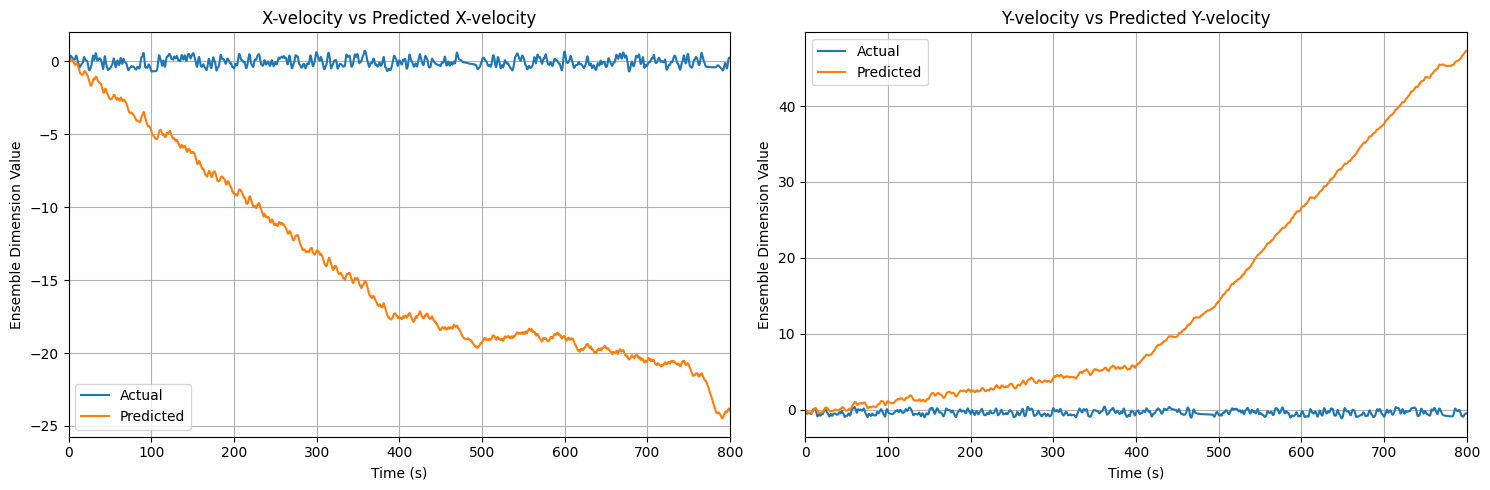

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(sim.trange(), true_vels[0])
ax1.plot(sim.trange(), pred_vels[0])
ax1.set_title("X-velocity vs Predicted X-velocity")
ax1.set_xlim((0,np.max(sim.trange())))
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Ensemble Dimension Value")
ax1.legend(["Actual", "Predicted"])
ax1.grid()

ax2.plot(sim.trange(), true_vels[1])
ax2.plot(sim.trange(), pred_vels[1])
ax2.set_title("Y-velocity vs Predicted Y-velocity")
ax2.set_xlim((0,np.max(sim.trange())))
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Ensemble Dimension Value")
ax2.legend(["Actual", "Predicted"])
ax2.grid()

fig.tight_layout()
plt.show()

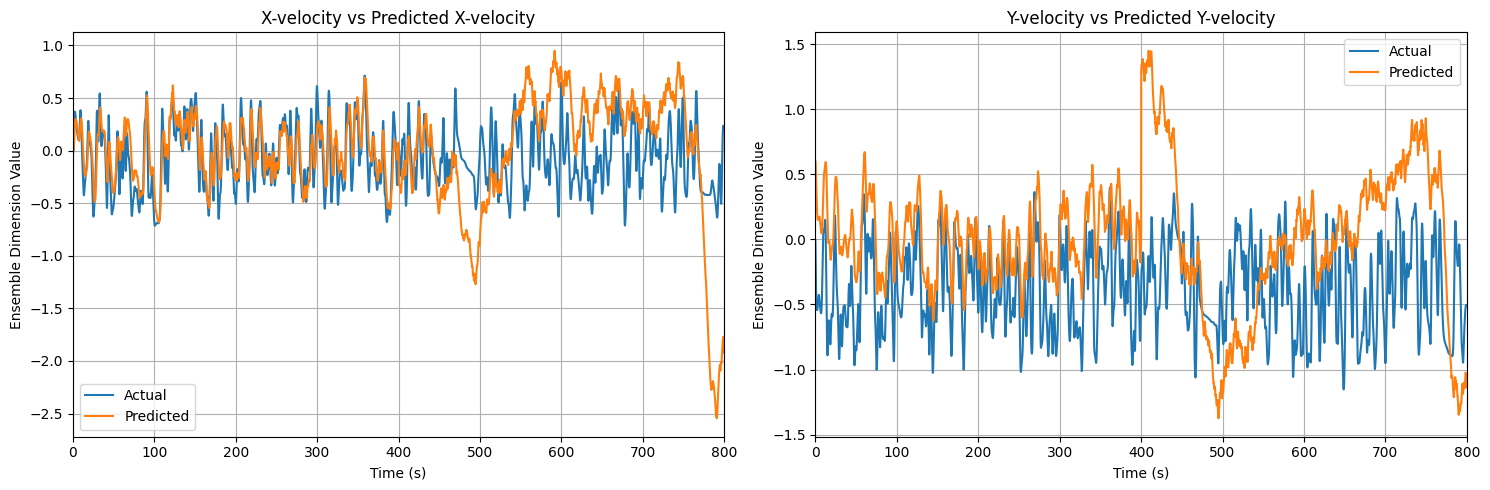

In [26]:
from scipy.signal import detrend

t_trainingstop = int(len(sim.trange())*0.5)-1
x_seg1 = detrend(pred_vels[0][:t_trainingstop])
x_seg2 = detrend(pred_vels[0][t_trainingstop:])
x_full = np.concatenate((x_seg1, x_seg2))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(sim.trange(), true_vels[0])
ax1.plot(sim.trange(), x_full)
ax1.set_title("X-velocity vs Predicted X-velocity")
ax1.set_xlim((0,np.max(sim.trange())))
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Ensemble Dimension Value")
ax1.legend(["Actual", "Predicted"])
ax1.grid()


y_seg1 = detrend(pred_vels[1][:t_trainingstop])
y_seg2 = detrend(pred_vels[1][t_trainingstop:])
y_full = np.concatenate((y_seg1, y_seg2))

ax2.plot(sim.trange(), true_vels[1])
ax2.plot(sim.trange(), y_full)
ax2.set_title("Y-velocity vs Predicted Y-velocity")
ax2.set_xlim((0,np.max(sim.trange())))
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Ensemble Dimension Value")
ax2.legend(["Actual", "Predicted"])
ax2.grid()

fig.tight_layout()
plt.show()
